In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer, TFDistilBertModel, DistilBertConfig
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
import nltk
from keras import Model
from keras.layers import Input, Bidirectional, GlobalMaxPool1D, Dense, Dropout, LSTM, Flatten
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.optimizers import Adam
from keras import Model
from keras.layers import Input, Bidirectional, GlobalMaxPool1D, Dense, Dropout, LSTM, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_curve, auc, average_precision_score
import seaborn as sb
from imblearn.under_sampling import RandomUnderSampler

Data source: https://www.kaggle.com/amananandrai/clickbait-dataset

# Project variables

In [2]:
m_name = "clickbait v2"
p_dir = os.path.join("../cb models", m_name)

In [3]:
def create_dir(dir_path: str):
    if not os.path.exists(dir_path):
        os.mkdir(dir_path)

In [4]:
def clear_dir(dir_path: str):
    for item in os.listdir(dir_path):
        fp = os.path.join(dir_path, item)
        if os.path.isfile(fp):
            os.remove(fp)
        if os.path.isdir(fp):
            rmtree(fp)

In [5]:
create_dir(p_dir)
clear_dir(p_dir)

# Prepare dataset

In [6]:
df = pd.read_csv("../cb models/clickbait_data.csv")
df.rename(columns={"headline": "title"}, inplace=True)
df = df.loc[df.title.str.len() <= 100, :]
df.shape

(31865, 2)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31865 entries, 0 to 31999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      31865 non-null  object
 1   clickbait  31865 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 746.8+ KB


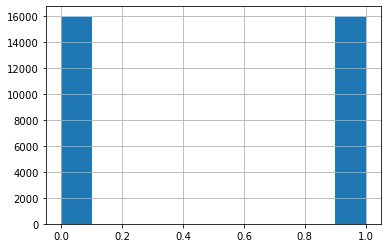

In [8]:
# cat_lbl = ["very low", "low", "high", "very high"]
# df.loc[:, "clickbait"] = pd.qcut(df.clickbait, len(cat_lbl), labels=cat_lbl, precision=6)
df["clickbait"].hist()
plt.show()

In [9]:
y = df["clickbait"]
x = df.loc[:, [c for c in df if c != "clickbait"]]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
# x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=4711)

x_train.to_pickle(os.path.join(p_dir, "x_train.pkl"))
y_train.to_pickle(os.path.join(p_dir, "y_train.pkl"))
# x_val.to_pickle(os.path.join(p_dir,"x_val.pkl"))
# y_val.to_pickle(os.path.join(p_dir, "y_val.pkl"))
x_test.to_pickle(os.path.join(p_dir,"x_test.pkl"))
y_test.to_pickle(os.path.join(p_dir, "y_test.pkl"))

print(x_train.shape[0], x_test.shape[0])

25492 6373


# Build the model

In [10]:
def preprocessing(df: pd.DataFrame, remove_stopwords: bool=False) -> pd.DataFrame:
    field = "title"
    stw = set(stopwords.words("english"))
    
    def cleanse_row(row, field, stw, stopwords=False):
        # Remove HTML from text
        soup = BeautifulSoup(row[field])
        row[field] = soup.get_text()
        
        # Remove stopwords
        if stopwords:
            row[field] = " ".join([w for w in row[field].split() if w not in stw])
        
        return row
    
    df = df.apply(lambda row: cleanse_row(row, field, stw, remove_stopwords), axis=1)
    return df["title"]

In [11]:
# Download the stopwork corpus
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
remove_stopwords = False

def preprocess_data(x: pd.DataFrame, remove_stopwords: bool=False) -> list():
    x_pp = preprocessing(x, remove_stopwords)
    x_pp = x_pp.tolist()
    return x_pp

In [13]:
x_train_pp = preprocess_data(x_train)
x_test_pp = preprocess_data(x_test)

In [14]:
pt_model = "distilbert-base-uncased"
tok = DistilBertTokenizer.from_pretrained(pt_model, do_lower=True, add_special_tokens=True, max_length=100, pad_to_max_length=True)

In [15]:
def tokenize(sentences, tokenizer):
    input_ids, input_masks, input_segments = [], [], []
    for sentence in sentences:
        inputs = tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=100, padding="max_length", return_attention_mask=True, 
                                       return_token_type_ids=True)
        input_ids.append(inputs["input_ids"])
        input_masks.append(inputs["attention_mask"])
        input_segments.append(inputs["token_type_ids"])
        
    return np.asarray(input_ids, dtype="int32"), np.asarray(input_masks, dtype="int32"), np.asarray(input_segments, dtype="int32")

In [16]:
config = DistilBertConfig(dropout=0.2, attention_dropout=0.2)
config.output_hidden_states=False
transformer_model = TFDistilBertModel.from_pretrained(pt_model, config=config)

in_ids = Input(shape=(100,), name="input_token", dtype="int32")
in_masks = Input(shape=(100,), name="masked_token", dtype="int32")

emb = transformer_model(in_ids, attention_mask=in_masks)[0]
x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.2, recurrent_dropout=0))(emb)
x = GlobalMaxPool1D()(x)
x = Flatten()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(2, activation="softmax")(x)

model = Model(inputs=[in_ids, in_masks], outputs=x)

for layer in model.layers[:3]:
    layer.trainable = False

2021-11-18 12:16:46.779735: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-18 12:16:46.789990: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-18 12:16:46.790750: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-18 12:16:46.792128: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [17]:
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer=Adam(learning_rate=0.0005), 
              metrics=["accuracy"])

In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_token (InputLayer)        [(None, 100)]        0                                            
__________________________________________________________________________________________________
masked_token (InputLayer)       [(None, 100)]        0                                            
__________________________________________________________________________________________________
tf_distil_bert_model (TFDistilB TFBaseModelOutput(la 66362880    input_token[0][0]                
                                                                 masked_token[0][0]               
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 100, 100)     327600      tf_distil_bert_model[0][0]   

In [19]:
x_train_tok = tokenize(x_train_pp, tok)
x_test_tok = tokenize(x_test_pp, tok)

lb = LabelBinarizer()
y_train_b = lb.fit_transform(y_train)
y_test_b = lb.transform(y_test)

batch_size = 64
n_epochs = 20

metric = "val_loss"

es = EarlyStopping(monitor=metric, 
                   mode="min", 
                   patience=5, 
                   restore_best_weights=True)

checkpoint = ModelCheckpoint(os.path.join(p_dir, "{}".format(m_name)), 
                             monitor=metric, 
                             verbose=2, 
                             save_best_only=True, 
                             save_weights_only=True, 
                             mode='min')

hist = model.fit(x_train_tok[:2], y_train_b, 
                 validation_data=(x_test_tok[:2], y_test_b), 
                 batch_size=batch_size, 
                 epochs=n_epochs, 
                 callbacks=[checkpoint, es])

2021-11-18 12:17:04.683965: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2021-11-18 12:17:12.093962: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


399/399 [==============================] - 120s 282ms/step - loss: 0.1044 - accuracy: 0.9635 - val_loss: 0.0548 - val_accuracy: 0.9799

Epoch 00001: val_loss improved from inf to 0.05479, saving model to ../cb models/clickbait v2/clickbait v2
Epoch 2/20
399/399 [==============================] - 111s 277ms/step - loss: 0.0635 - accuracy: 0.9777 - val_loss: 0.0434 - val_accuracy: 0.9842

Epoch 00002: val_loss improved from 0.05479 to 0.04339, saving model to ../cb models/clickbait v2/clickbait v2
Epoch 3/20
399/399 [==============================] - 111s 277ms/step - loss: 0.0533 - accuracy: 0.9811 - val_loss: 0.0443 - val_accuracy: 0.9851

Epoch 00003: val_loss did not improve from 0.04339
Epoch 4/20
399/399 [==============================] - 110s 277ms/step - loss: 0.0472 - accuracy: 0.9826 - val_loss: 0.0444 - val_accuracy: 0.9840

Epoch 00004: val_loss did not improve from 0.04339
Epoch 5/20
399/399 [==============================] - 111s 277ms/step - loss: 0.0396 - accuracy: 0.9852

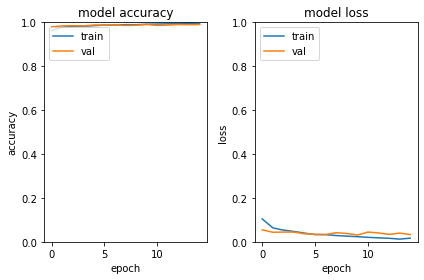

In [20]:
fig, axs = plt.subplots(1, 2)

axs[0].plot(hist.history["accuracy"])
axs[0].plot(hist.history["val_accuracy"])
axs[0].set_title("model accuracy")
axs[0].set_ylabel("accuracy")
axs[0].set_xlabel("epoch")
axs[0].set_ylim(0, 1)
axs[0].legend(["train", "val"], loc="upper left")

axs[1].plot(hist.history["loss"])
axs[1].plot(hist.history["val_loss"])
axs[1].set_title("model loss")
axs[1].set_ylabel("loss")
axs[1].set_xlabel("epoch")
axs[1].set_ylim(0, 1)
axs[1].legend(["train", "val"], loc="upper left")

plt.tight_layout()
plt.show()
fig.savefig(os.path.join(p_dir, "accuracy_loss.jpg"))

# Confusion matrix

In [21]:
model.load_weights(os.path.join(p_dir, "{}".format(m_name)))

## Training data (in-sample)

In [22]:
x_train_tok = tokenize(x_train_pp, tok)

lb = LabelBinarizer()
y_train_b = lb.fit_transform(y_train)

y_train_prob = model.predict(x_train_tok[:2], steps=y_train_b.shape[0])
y_pred = np.argmax(y_train_prob, axis=1)
y_pred = lb.inverse_transform(y_pred)

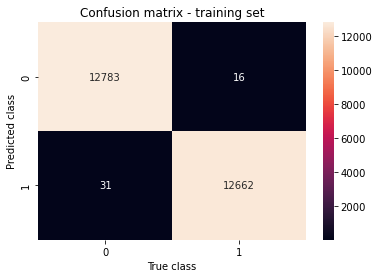

Accuracy: 1.00
Micro precision: 1.00
Micro recall: 1.00
Micro F1-score: 1.00
Macro precision: 1.00
Macro recall: 1.00
Macro F1-score: 1.00
Weighted precision: 1.00
Weighted recall: 1.00
Weighted F1-score: 1.00


In [23]:
cmtx = confusion_matrix(y_train, y_pred)
sb.heatmap(cmtx, annot=True, fmt="d", xticklabels=lb.classes_, yticklabels=lb.classes_)
plt.xlabel("True class")
plt.ylabel("Predicted class")
plt.title("Confusion matrix - training set")
plt.savefig(os.path.join(p_dir, "confusion_matrix_train.jpg"))
plt.show()

print("Accuracy: {:0.2f}".format(accuracy_score(y_train, y_pred)))

print("Micro precision: {:0.2f}".format(precision_score(y_train, y_pred, average="micro")))
print("Micro recall: {:0.2f}".format(recall_score(y_train, y_pred, average="micro")))
print("Micro F1-score: {:0.2f}".format(f1_score(y_train, y_pred, average="micro")))

print("Macro precision: {:0.2f}".format(precision_score(y_train, y_pred, average="macro")))
print("Macro recall: {:0.2f}".format(recall_score(y_train, y_pred, average="macro")))
print("Macro F1-score: {:0.2f}".format(f1_score(y_train, y_pred, average="macro")))

print("Weighted precision: {:0.2f}".format(precision_score(y_train, y_pred, average="weighted")))
print("Weighted recall: {:0.2f}".format(recall_score(y_train, y_pred, average="weighted")))
print("Weighted F1-score: {:0.2f}".format(f1_score(y_train, y_pred, average="weighted")))

## Test data (out-of-sample)

In [24]:
x_test_pp = preprocess_data(x_test)
x_test_tok = tokenize(x_test_pp, tok)

lb = LabelBinarizer()
y_train_b = lb.fit_transform(y_train)
y_test_b = lb.transform(y_test)

y_test_prob = model.predict(x_test_tok[:2], steps=y_test_b.shape[0])
y_pred = np.argmax(y_test_prob, axis=1)
y_pred = lb.inverse_transform(y_pred)

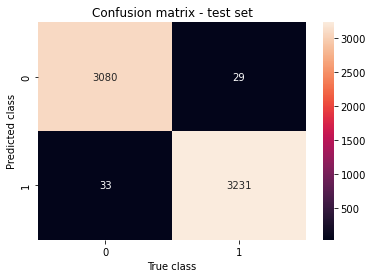

Accuracy: 0.99
Micro precision: 0.99
Micro recall: 0.99
Micro F1-score: 0.99
Macro precision: 0.99
Macro recall: 0.99
Macro F1-score: 0.99
Weighted precision: 0.99
Weighted recall: 0.99
Weighted F1-score: 0.99


In [25]:
cmtx = confusion_matrix(y_test, y_pred)
sb.heatmap(cmtx, annot=True, fmt="d", xticklabels=lb.classes_, yticklabels=lb.classes_)
plt.xlabel("True class")
plt.ylabel("Predicted class")
plt.title("Confusion matrix - test set")
plt.savefig(os.path.join(p_dir, "confusion_matrix_test.jpg"))
plt.show()

print("Accuracy: {:0.2f}".format(accuracy_score(y_test, y_pred)))

print("Micro precision: {:0.2f}".format(precision_score(y_test, y_pred, average="micro")))
print("Micro recall: {:0.2f}".format(recall_score(y_test, y_pred, average="micro")))
print("Micro F1-score: {:0.2f}".format(f1_score(y_test, y_pred, average="micro")))

print("Macro precision: {:0.2f}".format(precision_score(y_test, y_pred, average="macro")))
print("Macro recall: {:0.2f}".format(recall_score(y_test, y_pred, average="macro")))
print("Macro F1-score: {:0.2f}".format(f1_score(y_test, y_pred, average="macro")))

print("Weighted precision: {:0.2f}".format(precision_score(y_test, y_pred, average="weighted")))
print("Weighted recall: {:0.2f}".format(recall_score(y_test, y_pred, average="weighted")))
print("Weighted F1-score: {:0.2f}".format(f1_score(y_test, y_pred, average="weighted")))

# print(classification_report(y_test, y_pred, target_names=lb.classe_))

# ROC curve

## Training data (in-sample)

In [26]:
lb = LabelBinarizer()
lb.fit_transform(y_train)

y_train_no = lb.fit_transform(y_train)
y_pred_no = y_train_prob[:, 1]
fpr, tpr, thr = roc_curve(y_train_no, y_pred_no)

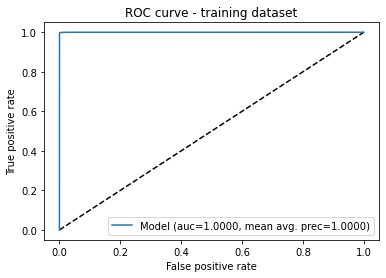

In [27]:
auc_model = auc(fpr, tpr)
mavgp = average_precision_score(y_train_no, y_pred_no)

plt.plot([0, 1], [0, 1], "k--")
plt.plot(fpr, tpr, label="Model (auc={:0.4f}, mean avg. prec={:0.4f})".format(auc_model, mavgp))
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve - training dataset")
plt.legend()
plt.savefig(os.path.join(p_dir, "roc-curve_train.jpg"))
plt.show()

## Test data (out-of-sample)

In [28]:
lb = LabelBinarizer()
lb.fit_transform(y_train)

y_test_no = lb.fit_transform(y_test)
y_pred_no = y_test_prob[:, 1]
fpr, tpr, thr = roc_curve(y_test_no, y_pred_no)

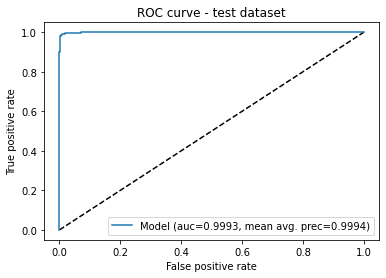

In [29]:
auc_model = auc(fpr, tpr)
mavgp = average_precision_score(y_test_no, y_pred_no)

plt.plot([0, 1], [0, 1], "k--")
plt.plot(fpr, tpr, label="Model (auc={:0.4f}, mean avg. prec={:0.4f})".format(auc_model, mavgp))
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve - test dataset")
plt.legend()
plt.savefig(os.path.join(p_dir, "roc-curve_test.jpg"))
plt.show()

# Class probability histograms

## Without middle classes

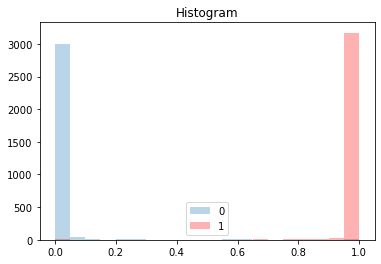

In [30]:
m0 = y_test_no[:, 0] == 0
c0 = y_test_prob[m0, 1]
m1 = y_test_no[:, 0] == 1
c1 = y_test_prob[m1, 1]

plt.hist(c0, alpha=0.3, bins=20)
plt.hist(c1, color="red", alpha=0.3, bins=20)
plt.title("Histogram")
plt.legend(lb.classes_)
plt.savefig(os.path.join(p_dir, "histogram.jpg"))
plt.show()

# Sample titles

In [31]:
combo = pd.concat([x_test, y_test], axis=1)
combo.reset_index(drop=True, inplace=True)
combo = pd.concat([combo, pd.Series(y_pred, name="pred")], axis=1)
combo.rename(columns={"clickbait": "truth"}, inplace=True)
combo.shape

(6373, 3)

In [32]:
g = combo.groupby(["pred"], as_index=False).apply(lambda x: x.sample(5, random_state=682))
g[["title", "pred"]].head(10)
g.to_csv(os.path.join(p_dir, "titles.csv"), index=False)
g.head(10)

title  truth  pred
0 3322  9 Police Officers Are Killed by Taliban in Afg...      0     0
  2985  Strong earthquake strikes off the coast of Taiwan      0     0
  674   Wales railway upgrade proposals would cost £5b...      0     0
  5784               Israeli PM Sharon rushed to hospital      0     0
  3381     British man charged with double murder in Iraq      0     0
1 721   This One-Question Quiz Will Tell You How Gulli...      1     1
  2091  Look At This Incredibly Rare Albino Baby Sea T...      1     1
  2264  The 27 Most Important Things Cats Did On The I...      1     1
  4358  This Baby's Reaction To Hearing About How She ...      1     1
  3598  I Spent A Week Trying To Be A More Assertive W...      1     1

# Save test set pred

In [33]:
y_pred_test = pd.Series(y_pred, name="y_pred_test")
y_pred_test.to_pickle(os.path.join(p_dir, "y_pred_test.pkl"))

# Apply model on Youtube data

In [34]:
import pandas as pd
import os
import numpy as np

In [35]:
m_dir = r"../nlp models/distilbert_2_classes_v3"

x_alien = pd.read_pickle(os.path.join(m_dir, "x_train.pkl"))
y_alien = pd.read_pickle(os.path.join(m_dir, "y_train.pkl"))

In [36]:
x_alien_pp = preprocess_data(x_alien)
x_alien_tok = tokenize(x_alien_pp, tok)

y_alien_prob = model.predict(x_alien_tok[:2], steps=y_alien.shape[0])
y_pred = np.argmax(y_alien_prob, axis=1)

In [37]:
x_combo = pd.concat([x_alien.reset_index(), y_alien.reset_index(), pd.Series(y_pred, name="pred")], axis=1)

In [38]:
x_combo[["title", "qtl", "pred"]].iloc[412:418, :]

,title,qtl,pred
412,This is why we can't have nice things,very high,1
413,Spring Full Course - Learn Spring Framework In...,very low,1
414,Platinum (version 2) - Periodic Table of Videos,very high,0
415,When To Quit (According to Computer Science),very high,1
416,Have astronomers disproved the Big Bang?,very high,0
417,Outtakes #1: Crash Course Philosophy,very low,0


In [39]:
x_combo["y"] = (x_combo["qtl"] == "very high").astype("int32")
x_combo["y"].corr(x_combo["pred"])

0.05673112640146389

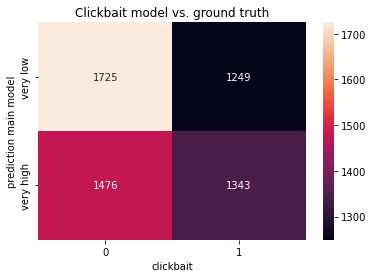

In [40]:
g = x_combo.groupby(["qtl", "pred"]).agg({"title": "count"}).reset_index()
g.rename(columns={"pred": "clickbait", "title": "count"}, inplace=True)
p = g.pivot(index="qtl", columns="clickbait", values="count")
sb.heatmap(p, annot=True, fmt="d")
plt.title("Clickbait model vs. ground truth")
plt.xlabel("clickbait")
plt.ylabel("prediction main model")
plt.savefig(os.path.join(p_dir, "confusion matrix clickbait vs ground truth.jpg"))
plt.show()

In [41]:
x_combo.loc[(x_combo["qtl"] == "very high") & (x_combo["pred"] == 0), "title"].head(10)

1      Gold, Sulfur, Vanadium and Cerium (feat. vsauce)
3                     Backspin Basketball Flies Off Dam
6     How Quantum Computers Break Encryption | Shor'...
7     How Do Solar Panels Work? (Physics of Solar Ce...
15                                      The World in UV
19    WORLD’S MOST AMAZING ARCHER in Slow Motion - S...
22                           Why Do Rivers Have Deltas?
24    How Sonar Works (Submarine Shadow Zone) - Smar...
27                     What is Impossible in Evolution?
30                                        What Is Fire?
Name: title, dtype: object

Why is the correlation not higher?

* Video thumbnails and titles can be changed over the lifetime of a Youtube video
* This might be related to the sample being from science/educational video. The typical viewer seems to also be attracted by videos clearly stating their content (Derek Muller also mentions such as case -> lava lamp video). May be because he is looking for something specific or because she is interested in the topic anyway.

In [42]:
x_combo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5793 entries, 0 to 5792
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   index               5793 non-null   int64              
 1   id_video            5793 non-null   object             
 2   title               5793 non-null   object             
 3   channel_id          5793 non-null   object             
 4   channel_name        5793 non-null   object             
 5   published_video     5793 non-null   datetime64[ns, UTC]
 6   like_count          5793 non-null   float64            
 7   dislike_count       5793 non-null   float64            
 8   view_count_video    5793 non-null   float64            
 9   published_mth       5793 non-null   int64              
 10  title_len           5793 non-null   int64              
 11  id_channel          5793 non-null   object             
 12  view_count_channel  5793 non-null 

In [43]:
g = x_combo.groupby(["channel_name"]).agg({"id_video": "count", "pred": "sum", "y": "sum"}).reset_index()
g.rename(columns={"id_video": "video_count", "pred": "clickbait", "y": "very high"}, inplace=True)
g["vh_ratio"] = g["very high"] / g["video_count"]
g["cb_ratio"] = g["clickbait"] / g["video_count"]

In [44]:
lbl = ["very low", "low", "high", "very high"]
g["success class"] = pd.cut(g["vh_ratio"], 4, labels=lbl)

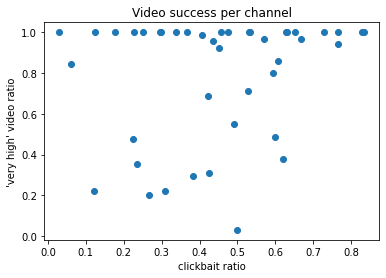

In [45]:
# c = ["red", "orange", "green", "blue"]
# i = 0
# for l in lbl:
#     plt.scatter(g.loc[g["success class"] == l, "cb_ratio"], g.loc[g["success class"] == l, "vh_ratio"], c=c[i])
#     i += 1
plt.scatter(g["cb_ratio"], g["vh_ratio"])
plt.xlabel("clickbait ratio")
plt.ylabel("\'very high\' video ratio")
plt.title("Video success per channel")
plt.savefig(os.path.join(p_dir, "channel level corr clickbait vs video success.jpg"))
plt.show()

In [46]:
c = g["cb_ratio"].corr(g["vh_ratio"])
print("{:0.2f}".format(c))

0.21


In [47]:
sp = g.loc[(g["cb_ratio"] < 0.25) & (g["vh_ratio"] > 0.8), :]
sp.sort_values(["vh_ratio", "cb_ratio"], ascending=False).head(10)

,channel_name,video_count,clickbait,very high,vh_ratio,cb_ratio,success class
29,Sixty Symbols,115,26,115,1.000000,0.226087,very high
0,3Blue1Brown,51,9,51,1.000000,0.176471,very high
21,Primer,8,1,8,1.000000,0.125000,very high
20,Physics Videos by Eugene Khutoryansky,33,1,33,1.000000,0.030303,very high
18,Periodic Videos,148,9,125,0.844595,0.060811,very high


Removing the 2 channels with a clickbait ratio of 0 but at the same time being super successful

In [48]:
g.loc[(g["cb_ratio"] == 0), "channel_name"]

Series([], Name: channel_name, dtype: object)

In [49]:
c = g.loc[(g["cb_ratio"] > 0), "cb_ratio"].corr(g.loc[(g["cb_ratio"] > 0), "vh_ratio"])
print("{:0.2f}".format(c))

0.21


In [50]:
c2 = g.loc[~((g["cb_ratio"] < 0.25) & (g["vh_ratio"] > 0.8)), "cb_ratio"].corr(
    g.loc[~((g["cb_ratio"] < 0.25) & (g["vh_ratio"] > 0.8)), "vh_ratio"])
print("{:0.2f}".format(c2))

0.43
